# Multi-class Refactoring Recommendation with SMOTE and Tree-based Algorithms
by Jerelyn Co (Jan 2018)

Main Reference: Kumar, L., & Sureka, A. (2017). Application of LSSVM and SMOTE on Seven Open Source Projects for Predicting Refactoring at Class Level. Asia-Pacific Software Engineering Conference (APSEC 2017), 90–99. https://doi.org/10.1109/APSEC.2017.15

In [146]:
import os

import numpy as np
import pandas as pd

import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

from sklearn.model_selection import KFold,train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
import statsmodels.api as sm

from sklearn.metrics import recall_score, classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve,roc_curve, auc, roc_auc_score, average_precision_score

from collections import Counter


%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 10,5

sns.set(style="darkgrid")

/home/jerelyn/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


### Classification Utils

In [2]:
def get_inputs(data, features, label, binary_csf=True):
    if binary_csf:
        raw_X, y = data[features], data[label]
    else:
        # Label encoding for refactoring types. Transforming categorical labels to 0 to n_classes - 1.
        le = preprocessing.LabelEncoder()
        le.fit(data[label])
        data[label] = le.transform(data[label])
        raw_X, y = data[features], data[label]
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(raw_X)
    return X, y.values.ravel()

In [3]:
def metrics_report(est, true, pred):
    print('Model Report:')
    print(classification_report(true, pred))

    fp_rate, tp_rate, thresholds = roc_curve(true, pred)
    print("AUC: {}".format(auc(fp_rate, tp_rate)))
    print("Accuracy Report: {}".format(accuracy_score(true, pred) * 100))

In [4]:
def prc(est, X_test, y_test):
    precision, recall, _ = precision_recall_curve(y_test, est.predict_proba(X_test)[:,1])
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve')
    return 1

In [5]:
def feature_importances(est, features):
    importances = est.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(len(features)), importances[indices],
           color="r", align="center")
    
    plt.xticks(range(len(features)), [features[i] for i in indices], rotation="vertical")
    plt.xlim([-1, len(features)])
    plt.show()
    
    return [features[i] for i in indices]

In [6]:
def XGB(X_train, y_train, X_test, y_test, param_test):
    n_neg, n_pos = np.bincount(y_test)
    clf_xgb = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic", eval_metric="map",
                                                       scale_pos_weight=n_neg/n_pos, num_boost_round=999,
                                                       early_stopping_round=10,seed=RAND_STATE, nthread=1), 
                          param_grid=param_test, cv=CV)

    mod = clf_xgb.fit(X_train, y_train)
    y_true, y_pred = y_test, mod.predict(X_test)

    metrics_report(clf_xgb.best_estimator_, y_test, y_pred)
    return clf_xgb.best_estimator_, y_true, y_pred
    

In [7]:
def svc(X_train, y_train, X_test, y_test, param_test):
    clf_svc = GridSearchCV(svm.SVC(kernel='rbf', probability=True), param_test, cv=CV)
    mod = clf_svc.fit(X, y)
    y_true, y_pred = y_test, mod.predict(X_test)
    
    metrics_report(clf_svc.best_estimator_, y_test, est.predict(X_test))
    return clf_svc.best_estimator_, y_true, y_pred

In [8]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')

### Load Datasets

In [115]:
ant_dir = "data/raw/badsmells/data/apache-ant/apache-ant/"
xerces_dir = "data/raw/badsmells/data/apache-ant/xerces-j/"

ddata_dir = "data/transformed/"

In [116]:
data_df_csf = pd.read_csv(ddata_dir+"proc_prod.csv")
# Create a binary label column.
data_df_csf["w_ref"] = data_df_csf["Refactoring"].apply(lambda x: 0 if x =="not" else 1)
data_df_csf.head()

,Refactoring,Version_x,Class,AG,NDC,ADD,DEL,CHURN,nsplit,Version_y,...,ComplexClass,LazyClass,LongMethod,LongParameterList,MessageChain,RPB,SpaghettiCode,SpeculativeGenerality,FeatureEnvy,w_ref
0,not,1.5,main.org.apache.tools.ant.Diagnostics,18638363,3,20.0,4.0,204.0,1,1.6.4,...,0,0,0,0,0,0,0,0,0,0
1,not,1.5,main.org.apache.tools.ant.Diagnostics,18638363,3,20.0,4.0,204.0,1,1.7.1,...,0,0,0,0,0,0,0,0,0,0
2,not,1.5.4,main.org.apache.tools.ant.Diagnostics,18638363,3,20.0,4.0,204.0,1,1.6.4,...,0,0,0,0,0,0,0,0,0,0
3,not,1.5.4,main.org.apache.tools.ant.Diagnostics,18638363,3,20.0,4.0,204.0,1,1.7.1,...,0,0,0,0,0,0,0,0,0,0
4,not,1.5,main.org.apache.tools.ant.filters.LineContains,30192410,3,19.0,11.0,1911.0,1,1.6.4,...,0,0,0,0,0,0,0,0,0,0


In [117]:
info_cols = ['Version_x',  'Version_y', 'Class', 'nsplit']
bin_label = ['w_ref']
multi_label = ["Refactoring"]
proc_cols = ['AG', 'NDC', 'ADD', 'DEL', 'CHURN']
prod_cols = ['LOC', 'WMC', 'DIT', 'NOC', 'RFC','CBO', 'LCOM', 'NOM', 'NOA', 'NOO', 'CCBC', 'C3']
bs_cols = ['BLOB', 'CDSBP', 'ComplexClass', 'LazyClass', 'LongMethod', 'LongParameterList', 'MessageChain', 'RPB',
           'SpaghettiCode', 'SpeculativeGenerality', 'FeatureEnvy',]

In [118]:
data_df_csf.dropna(inplace=True)
data_df_csf.drop_duplicates(inplace=True)

In [119]:
data_df_csf.groupby(["proj", "w_ref"])["Class"].count()

proj        w_ref
apache-ant  0          389
            1          205
xerces2-j   0        53754
            1         1354
Name: Class, dtype: int64

## Binary Classification

In [120]:
TEST_SIZE = 0.3
RAND_STATE = 12
CV = 5

In [121]:
svc_param_grid = {'C': [0.01, 0.1, 5], 'gamma' : [0.001, 0.01, 0.1, 1]}
xgb_param_grid = {
    'n_estimators':[100,150,200],
    'max_depth': [6, 9, 12],
}

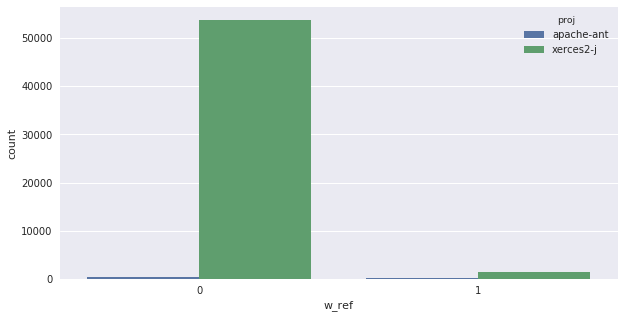

In [122]:
ax = sns.countplot(x="w_ref", data=data_df_csf, hue="proj")

Use of PRC 

Saito, T., & Rehmsmeier, M. (2015). The precision-recall plot is more informative than the ROC plot when evaluating binary classifiers on imbalanced datasets. PLoS ONE, 10(3), 1–21. https://doi.org/10.1371/journal.pone.011843

https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/

Data is severely screwed to the negative class (without refactoring). 

Application of SMOTE to balance this severely screwed data may not be a good idea.

Try out cluster centroids.
http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.under_sampling.ClusterCentroids.html

In [123]:
proj = "apache-ant"
data_df_csf = data_df_csf[data_df_csf["proj"]==proj]

In [142]:
features = prod_cols + proc_cols
X, y = get_inputs(data_df_csf, features, bin_label)

In [143]:
rcParams['figure.figsize'] = 10,10

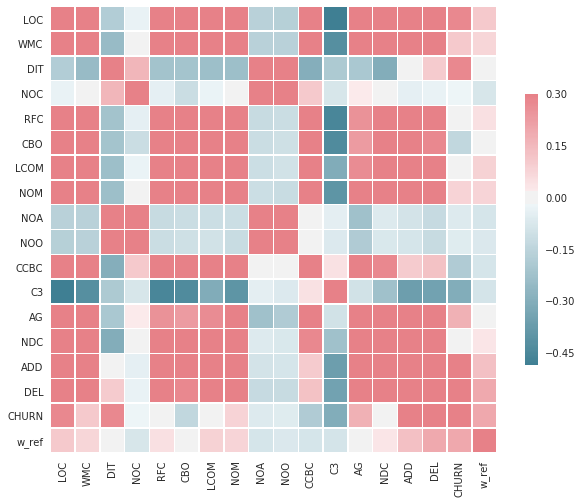

In [144]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data_df_csf[features+bin_label].corr(), cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)

## Using XGBoost

[Kaggle Introduction](https://www.kaggle.com/babatee/intro-xgboost-classification)

http://xgboost.readthedocs.io/en/latest//parameter.html

http://xgboost.readthedocs.io/en/latest//how_to/param_tuning.html

### All features

In [153]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [163]:
res = sm.Logit(y_train, X_train).fit()

print(res.summary())
OR = np.exp(res.params)

Optimization terminated successfully.
         Current function value: 0.577306
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  415
Model:                          Logit   Df Residuals:                      398
Method:                           MLE   Df Model:                           16
Date:                Mon, 15 Jan 2018   Pseudo R-squ.:                 0.07960
Time:                        14:36:04   Log-Likelihood:                -239.58
converged:                       True   LL-Null:                       -260.30
                                        LLR p-value:                 0.0004782
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             6.1744      4.439      1.391      0.164      -2.527      14.876
x2           -10.7352      5

<BarContainer object of 17 artists>

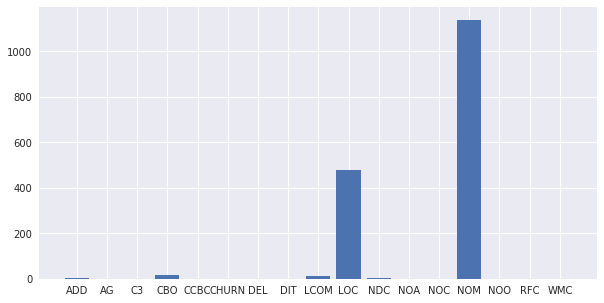

In [164]:
plt.bar(x=features, height=OR)

Model Report:
             precision    recall  f1-score   support

          0       0.60      0.57      0.59       107
          1       0.41      0.44      0.43        72

avg / total       0.53      0.52      0.52       179

AUC: 0.5072689511941848
Accuracy Report: 51.955307262569825


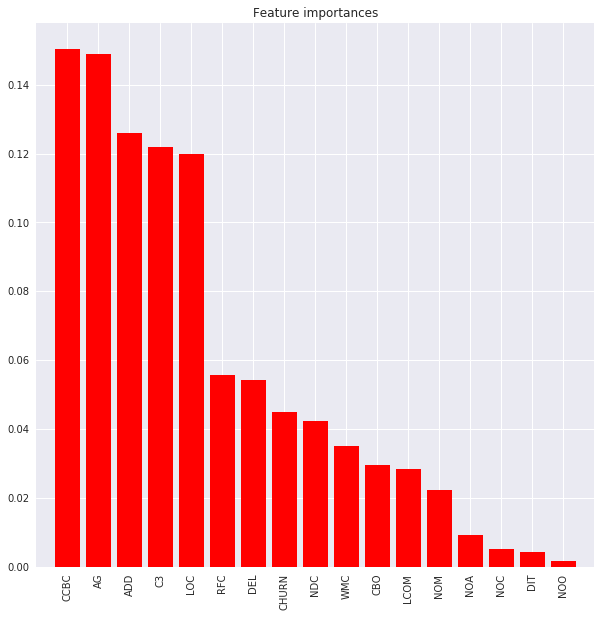

CPU times: user 4.89 s, sys: 91.9 ms, total: 4.99 s
Wall time: 4.99 s


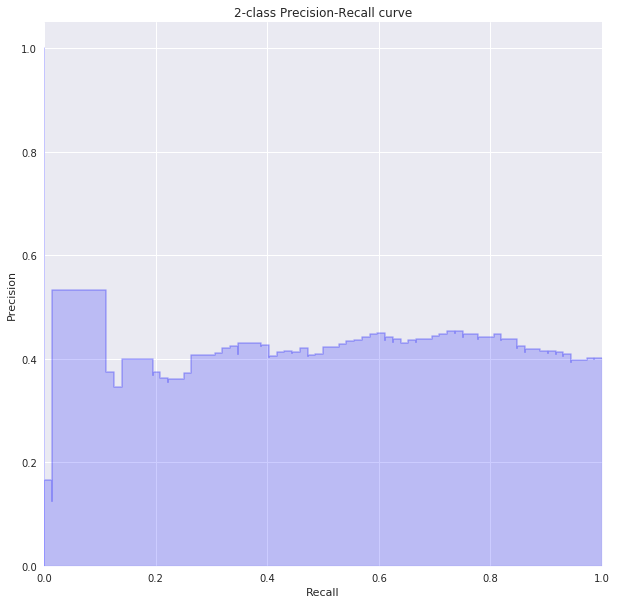

In [110]:
%%time
est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, xgb_param_grid)
feature_ranks = feature_importances(est, features)
prc(est, X_test, y_test)

Let's try to reduce features by using the RF's built-in feature importances

### Reduced features

Model Report:
             precision    recall  f1-score   support

          0       0.60      0.56      0.58       107
          1       0.41      0.44      0.42        72

avg / total       0.52      0.51      0.52       179

AUC: 0.5025960539979232
Accuracy Report: 51.39664804469274
CPU times: user 2.47 s, sys: 55.9 ms, total: 2.52 s
Wall time: 2.52 s


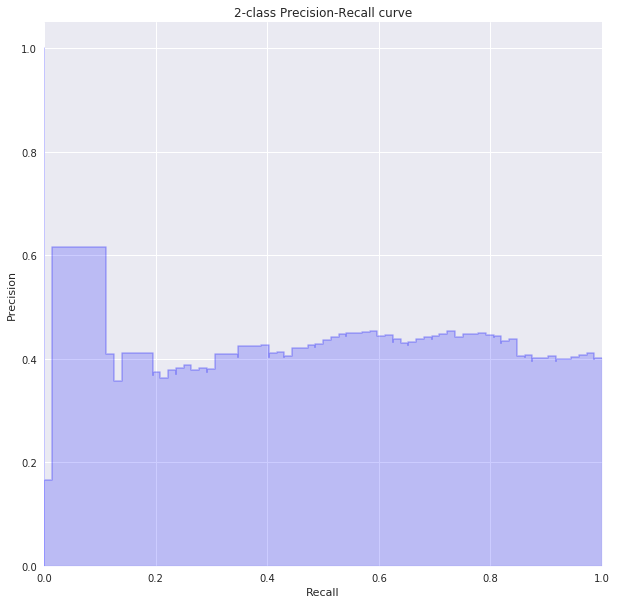

In [111]:
%%time
top_features = [i for i in feature_ranks[:5]]
X, y = get_inputs(data_df_csf, top_features, bin_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)
est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, xgb_param_grid)
prc(est, X_test, y_test)

### Product Metrics only

Model Report:
             precision    recall  f1-score   support

          0       0.70      0.60      0.64       107
          1       0.51      0.61      0.55        72

avg / total       0.62      0.60      0.61       179

AUC: 0.6046209761163033
Accuracy Report: 60.33519553072626
CPU times: user 3.09 s, sys: 83.9 ms, total: 3.17 s
Wall time: 3.17 s


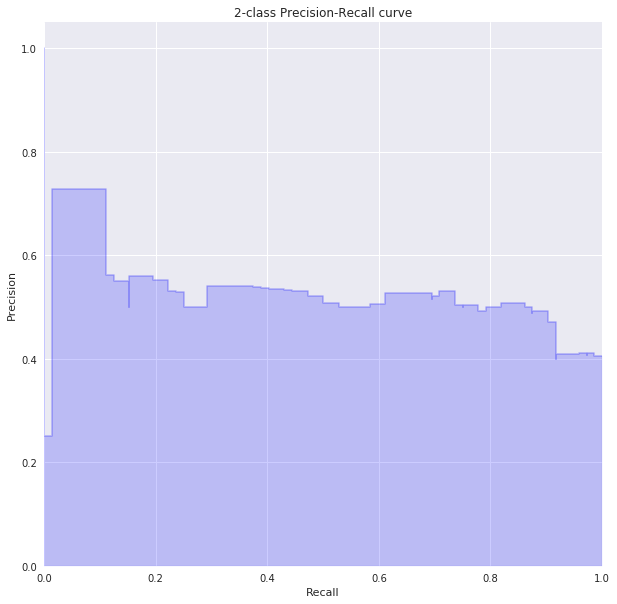

In [112]:
%%time
top_features = prod_cols
X, y = get_inputs(data_df_csf, top_features, bin_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)
est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, xgb_param_grid)
prc(est, X_test, y_test)

### Process Metrics only

Model Report:
             precision    recall  f1-score   support

          0       0.59      0.57      0.58       107
          1       0.39      0.40      0.39        72

avg / total       0.51      0.50      0.50       179

AUC: 0.48643561786085143
Accuracy Report: 50.27932960893855
CPU times: user 2.34 s, sys: 100 ms, total: 2.44 s
Wall time: 2.44 s


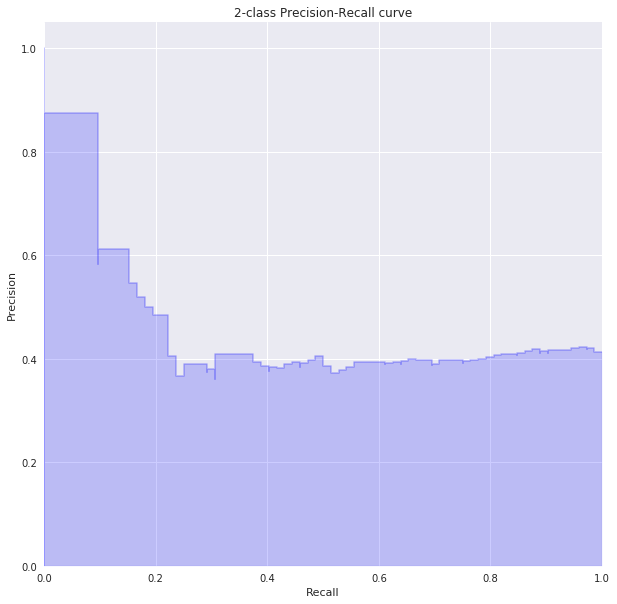

In [113]:
%%time
top_features = proc_cols
X, y = get_inputs(data_df_csf, top_features, bin_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)
est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, xgb_param_grid)
prc(est, X_test, y_test)

Model Report:
             precision    recall  f1-score   support

          0       0.65      0.75      0.70       107
          1       0.52      0.40      0.45        72

avg / total       0.60      0.61      0.60       179

AUC: 0.5752206645898235
Accuracy Report: 60.893854748603346
CPU times: user 1.17 s, sys: 56.3 ms, total: 1.22 s
Wall time: 1.45 s


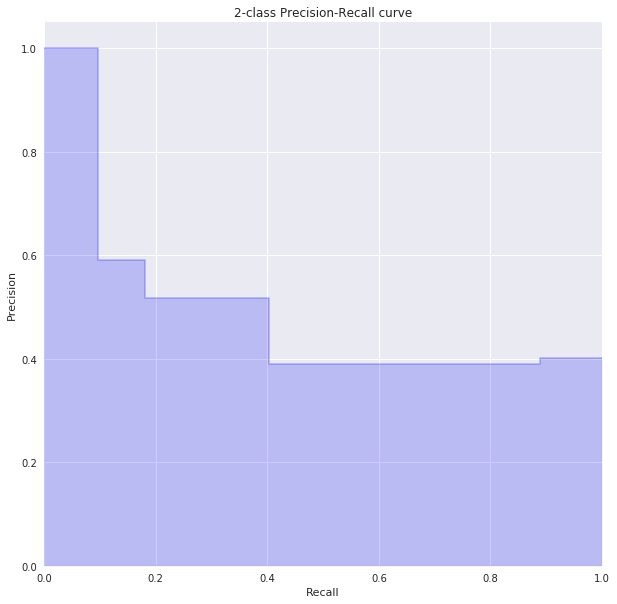

In [92]:
%%time
top_features = bs_cols
X, y = get_inputs(data_df_csf, top_features, bin_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)
est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, xgb_param_grid)
prc(est, X_test, y_test)

## Using MLP

In [133]:
mlp = MLPClassifier(hidden_layer_sizes=(13,13,13), max_iter=500)
mlp.fit(X_train,y_train)
y_pred = mlp.predict(X_test)
fp_rate, tp_rate, thresholds = roc_curve(y_test, y_pred)
print("AUC: {}".format(auc(fp_rate, tp_rate)))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

AUC: 0.5486111111111112
[[107   0]
 [ 65   7]]
             precision    recall  f1-score   support

          0       0.62      1.00      0.77       107
          1       1.00      0.10      0.18        72

avg / total       0.77      0.64      0.53       179



### Applying SMOTE to dataset. 
As we have seen during our data exploration, the dataset is severely imbalanced.

Reference: [Becker](https://www.google.co.jp/search?client=ubuntu&channel=fs&q=ROC+auc+curve+in+python&ie=utf-8&oe=utf-8&gfe_rd=cr&dcr=0&ei=EE1UWuPXNcyQ8QfT1YbAAw)

Let's try again

In [134]:
features = prod_cols + proc_cols + bs_cols
X, y = get_inputs(data_df_csf, features, bin_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)


[282 133]
[282 169]
CPU times: user 77.1 ms, sys: 29 µs, total: 77.1 ms
Wall time: 110 ms


/home/jerelyn/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


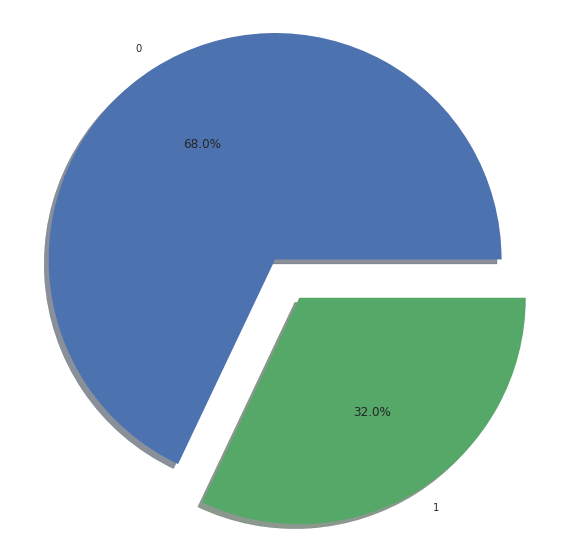

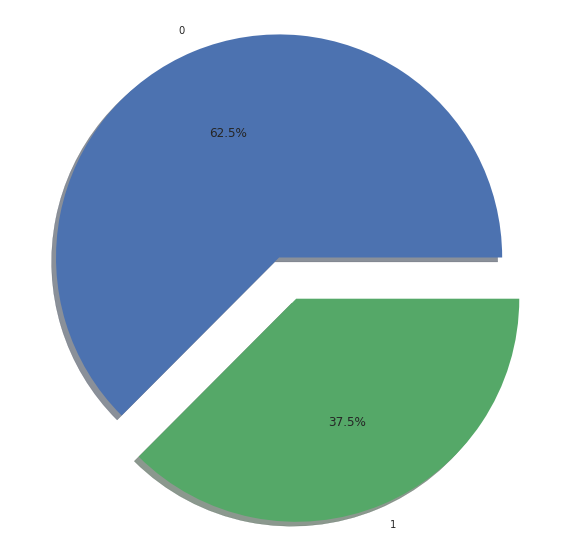

In [135]:
%%time

plot_pie(y_train)
print(np.bincount(y_train))
sm = SMOTE(random_state=RAND_STATE, ratio=0.6)
X_train, y_train = sm.fit_sample(X_train, y_train)
print(np.bincount(y_train))
plot_pie(y_train)


In [136]:
np.bincount(y_train)

array([282, 169])

Model Report:
             precision    recall  f1-score   support

          0       0.61      0.56      0.58       107
          1       0.41      0.46      0.43        72

avg / total       0.53      0.52      0.52       179

AUC: 0.5095404984423676
Accuracy Report: 51.955307262569825


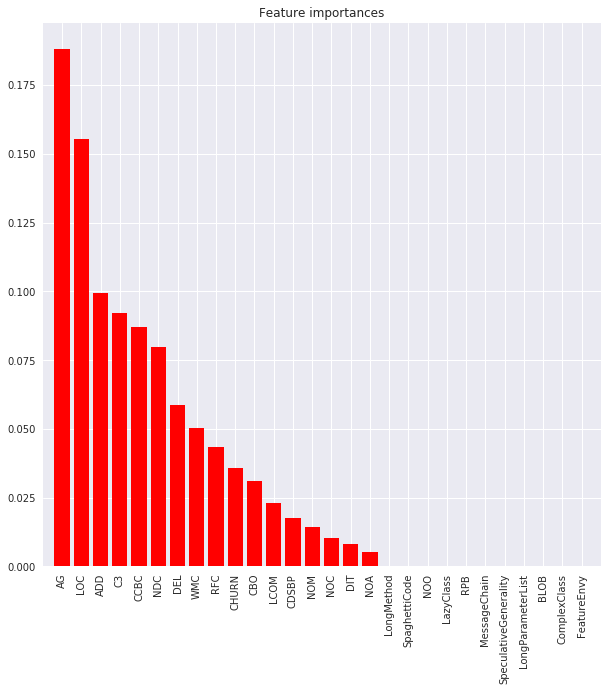

1

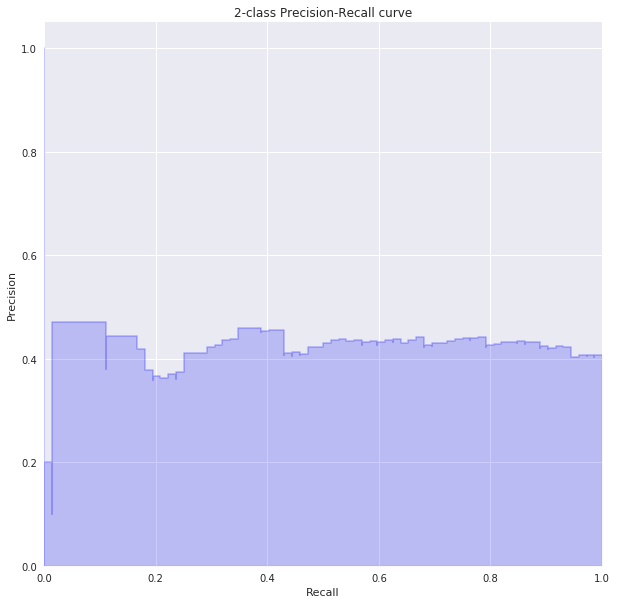

In [137]:
est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, xgb_param_grid)
feature_ranks = feature_importances(est, features)
prc(est, X_test, y_test)

Model Report:
             precision    recall  f1-score   support

          0       0.60      0.56      0.58       107
          1       0.41      0.44      0.42        72

avg / total       0.52      0.51      0.52       179

AUC: 0.5025960539979232
Accuracy Report: 51.39664804469274
CPU times: user 2.7 s, sys: 67.9 ms, total: 2.77 s
Wall time: 2.77 s


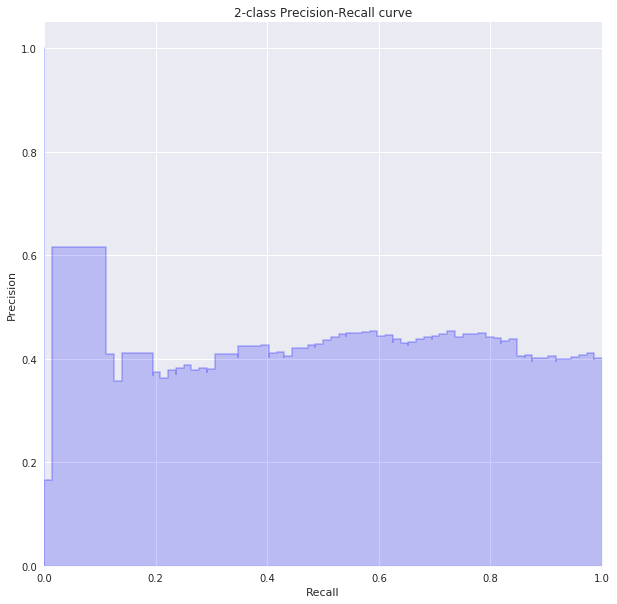

In [138]:
%%time
top_features = [i for i in feature_ranks[:5]]
X, y = get_inputs(data_df_csf, top_features, bin_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)
est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, xgb_param_grid)
prc(est, X_test, y_test)

Model Report:
             precision    recall  f1-score   support

          0       0.70      0.60      0.64       107
          1       0.51      0.61      0.55        72

avg / total       0.62      0.60      0.61       179

AUC: 0.6046209761163033
Accuracy Report: 60.33519553072626


1

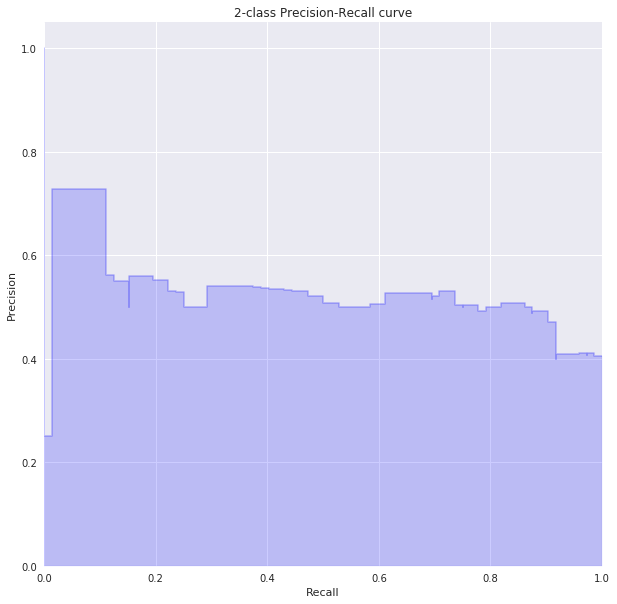

In [98]:
# %%time
top_features = prod_cols
X, y = get_inputs(data_df_csf, top_features, bin_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)
est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, xgb_param_grid)
prc(est, X_test, y_test)

Model Report:
             precision    recall  f1-score   support

          0       0.59      0.57      0.58       107
          1       0.39      0.40      0.39        72

avg / total       0.51      0.50      0.50       179

AUC: 0.48643561786085143
Accuracy Report: 50.27932960893855
CPU times: user 2.52 s, sys: 68 ms, total: 2.59 s
Wall time: 2.59 s


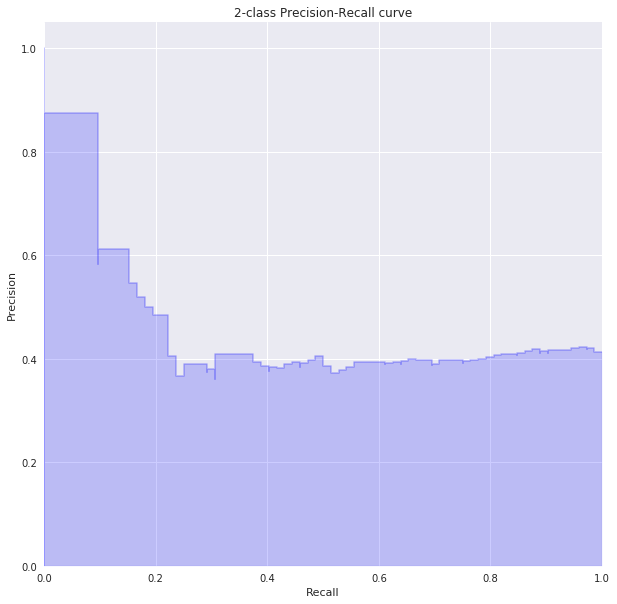

In [99]:
%%time
top_features = proc_cols
X, y = get_inputs(data_df_csf, top_features, bin_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)
est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, xgb_param_grid)
prc(est, X_test, y_test)

Model Report:
             precision    recall  f1-score   support

          0       0.65      0.75      0.70       107
          1       0.52      0.40      0.45        72

avg / total       0.60      0.61      0.60       179

AUC: 0.5752206645898235
Accuracy Report: 60.893854748603346
CPU times: user 1.32 s, sys: 32.1 ms, total: 1.35 s
Wall time: 1.35 s


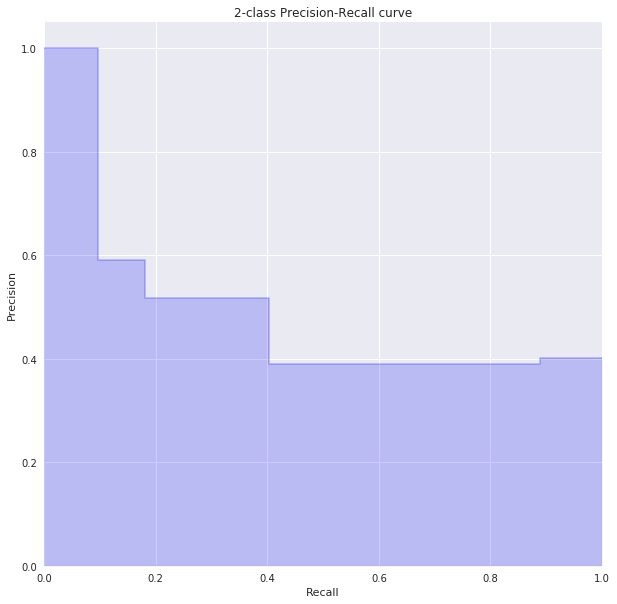

In [100]:
%%time
top_features = bs_cols
X, y = get_inputs(data_df_csf, top_features, bin_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)
est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, xgb_param_grid)
prc(est, X_test, y_test)

In [140]:
%%time
top_features = [i for i in feature_ranks[:5]]
X, y = get_inputs(data_df_csf, top_features, bin_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)

mlp = MLPClassifier(hidden_layer_sizes=(13,13,13), max_iter=500)
mlp.fit(X_train,y_train)
y_pred = mlp.predict(X_test)
fp_rate, tp_rate, thresholds = roc_curve(y_test, y_pred)
print("AUC: {}".format(auc(fp_rate, tp_rate)))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

AUC: 0.5
[[107   0]
 [ 72   0]]
             precision    recall  f1-score   support

          0       0.60      1.00      0.75       107
          1       0.00      0.00      0.00        72

avg / total       0.36      0.60      0.45       179

CPU times: user 161 ms, sys: 4.04 ms, total: 166 ms
Wall time: 85.7 ms


/home/jerelyn/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [141]:
%%time
top_features = prod_cols
X, y = get_inputs(data_df_csf, top_features, bin_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)

mlp = MLPClassifier(hidden_layer_sizes=(13,13,13), max_iter=500)
mlp.fit(X_train,y_train)
y_pred = mlp.predict(X_test)
fp_rate, tp_rate, thresholds = roc_curve(y_test, y_pred)
print("AUC: {}".format(auc(fp_rate, tp_rate)))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

AUC: 0.5486111111111112
[[107   0]
 [ 65   7]]
             precision    recall  f1-score   support

          0       0.62      1.00      0.77       107
          1       1.00      0.10      0.18        72

avg / total       0.77      0.64      0.53       179

CPU times: user 337 ms, sys: 4.02 ms, total: 341 ms
Wall time: 172 ms


## Cluster Centroids

Model Report:
             precision    recall  f1-score   support

          0       0.67      0.43      0.52       107
          1       0.45      0.68      0.54        72

avg / total       0.58      0.53      0.53       179

AUC: 0.5552310488058152
Accuracy Report: 53.072625698324025


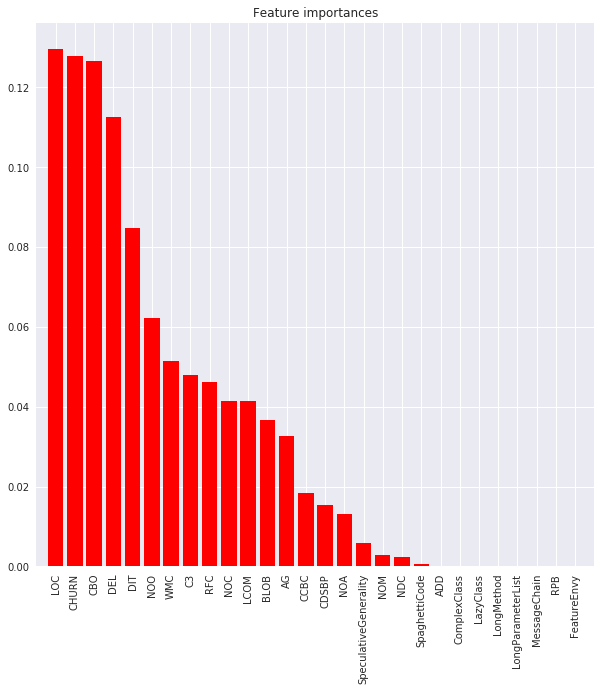

1

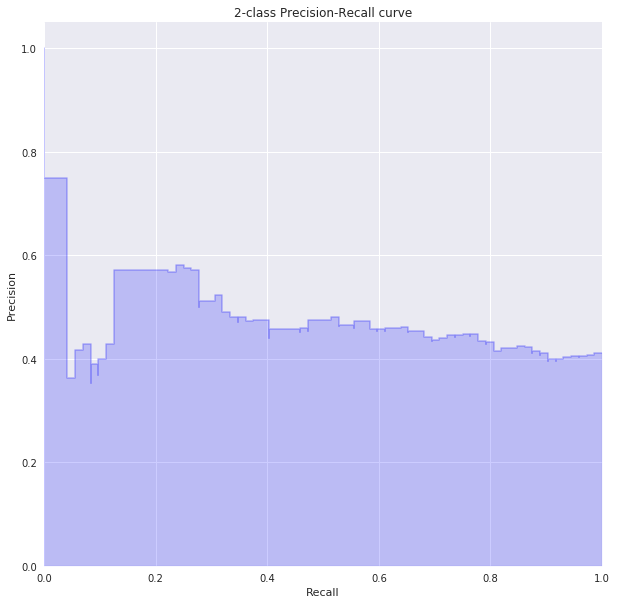

In [70]:
# Apply Cluster Centroids
top_features = proc_cols + prod_cols + bs_cols
X, y = get_inputs(data_df_csf, top_features, bin_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)

cc = ClusterCentroids()
X_train, y_train = cc.fit_sample(X_train, y_train)

est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, xgb_param_grid)
feature_ranks = feature_importances(est, features)
prc(est, X_test, y_test)

Model Report:
             precision    recall  f1-score   support

          0       0.64      0.46      0.53       107
          1       0.43      0.61      0.51        72

avg / total       0.55      0.52      0.52       179

AUC: 0.5345275181723781
Accuracy Report: 51.955307262569825


1

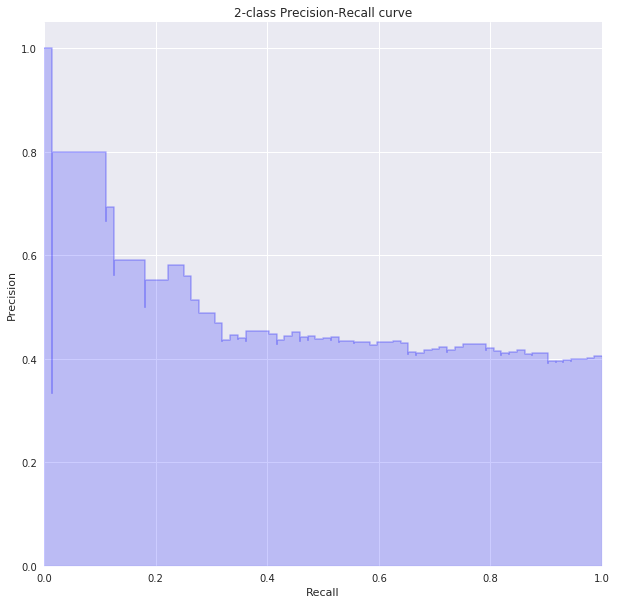

In [71]:
# Apply Cluster Centroids
top_features = [i for i in feature_ranks[:4]]
X, y = get_inputs(data_df_csf, top_features, bin_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)

cc = ClusterCentroids()
X_train, y_train = cc.fit_sample(X_train, y_train)

est, y_true, y_pred = XGB(X_train, y_train, X_test, y_test, xgb_param_grid)
prc(est, X_test, y_test)

## What was done
- Multi-class prediction

## Preliminary Findings

- Despite the innate capability of tree-based algorithms to somehow compensate for unbalanced datasets, resampling has to be done in this specific application because of the severely unbalanced dataset. If we don't, then training would be problematic as there will be some classes that may be severely under-represented / zero.

## What else can be done

- Try out binary classification
- Hyperparameter tuning in XGBoost
- ROC AUC Curves
- Confusion Matrix
- Feature selection using the results of the algorithms' features significance
- Compare XGBoost's performance

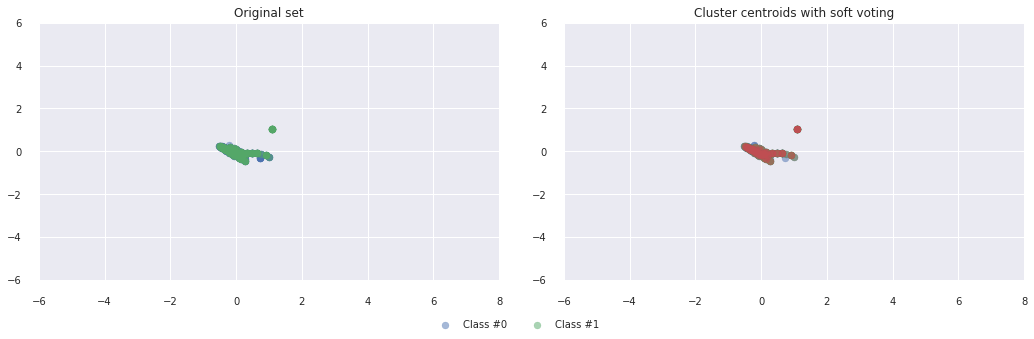

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X)

# Apply Cluster Centroids
cc = ClusterCentroids()
X_res, y_res = cc.fit_sample(X, y)
X_res_vis = pca.transform(X_res)

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

c0 = ax1.scatter(X_vis[y == 0, 0], X_vis[y == 0, 1], label="Class #0",
                 alpha=0.5)
c1 = ax1.scatter(X_vis[y == 1, 0], X_vis[y == 1, 1], label="Class #1",
                 alpha=0.5)
ax1.set_title('Original set')

ax2.scatter(X_res_vis[y_res == 0, 0],
            X_res_vis[y_res == 0, 1],
            label="Class #0", alpha=.5)
ax2.scatter(X_res_vis[y_res == 1, 0],
            X_res_vis[y_res == 1, 1],
            label="Class #1", alpha=.5)
c2 = ax2.scatter(X_vis[y == 1, 0],
                 X_vis[y == 1, 1], label="Original #1",
                 alpha=0.2)
ax2.set_title('Cluster centroids with soft voting')

# make nice plotting
for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([-6, 8])
    ax.set_ylim([-6, 6])

plt.figlegend((c0, c1), ('Class #0', 'Class #1', 'Original Class #1'),
              loc='lower center',
              ncol=3, labelspacing=0.)
plt.tight_layout(pad=3)
plt.show()